# SMAP para Bacia de Camargos - Calibração e Validação

#### Define functions

In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np

def lines_gradient(df, title='Comparação das Séries ao Longo do Tempo'):

    x = df.index

    num_lines = len(df.columns) - 1
    cmap = plt.get_cmap('viridis')  # You can choose other colormaps like 'plasma', 'inferno', etc.
    colors = [cmap(i) for i in np.linspace(0, 1, num_lines)]  # Generate gradient colors

    # Create the figure
    fig = go.Figure()
    
    # Add the 'Valor Real' trace
    fig.add_trace(go.Scatter(x=x, y=df['Q - OBS'], 
                             mode='lines', name='Valor Real', 
                             line=dict(color='black', width=2)))
    
    # Loop through the data and add a line for each set
    for i, col in enumerate(df.iloc[:1].drop(['Q - OBS'], axis=1).columns):
        fig.add_trace(go.Scatter(
            x=x, 
            y=df[col], 
            mode='lines', 
            name=col,
            line=dict(dash='dash', width=2, color=f'rgba{colors[i]}')
        ))

    # Set the title and labels
    fig.update_layout(
        title=title,
        xaxis_title='Data',
        yaxis_title='Vazão de Água (m3/dia)',
        legend_title='Séries',
        template='plotly_white'
    )
    
    # Show the interactive plot
    fig.show()

    return fig

#### Carregar os dados

In [2]:
import pandas as pd
import warnings; warnings.filterwarnings('ignore')

df = pd.read_csv('data/bacia-camargos.csv')

# Data cleaning
df['Ep'] = df['Ep'].str.replace(',', '.').astype('float')
df['Pr'] = df['Pr'].str.replace(',', '.').astype('float')

df.set_index(pd.to_datetime(df['data']), inplace=True)
df.drop('data', axis=1, inplace=True)

df.head()

,Qobs,Ep,Pr
data,,,
1995-01-01,204,4.94,4.3
1995-01-02,181,4.94,9.1
1995-01-03,176,4.94,22.8
1995-01-04,194,4.94,9.2
1995-01-05,198,4.94,1.7


---
# Modelo Base

#### Reference

In [ ]:
'Str': '100, 2000 (mm)'
'K2t': '0.2, 10 (dia)'
'Crec': '0, 100 (%)'
'Capc': '30, 50 (%)'
'Kkt': '30, 180 (dia)'
'H': '0, 300 (mm)'
'Ai': '2, 5 (mm)'
'K1t': '0.2, 10 (dia)'
'K3t': '10, 60 (dia)'
'kep': '0.8, 1.2'

#### Parâmetros usando o meio dos intervalos

In [5]:
params_middle = dict(
    Str = 1000,  
    Crec = 50,  
    Capc = 40.0, 
    kep = 1.0, 
    K2t = 5.0,  
    K1t = 5.0,  
    K3t = 35.0, 
    Kkt = 100,  
    Ai = 3.5,  
    H = 150, 
    
    # Não otimizáveis
    Ad = 6279.0, 
    Pcof = 1.0,  
    Tuin = 20.0, 
    Ebin = 45.0, 
    Supin = 1.0, 
)

#### Parâmetros ótimos da ONS

In [6]:
# Define default parameters
params_ons = dict(
    Ad = 6279.0, 
    Str = 100.0,  
    K2t = 5.5, 
    Crec = 100, 
    Ai = 2, 
    Capc = 42.0, 
    Kkt = 150, 
    Pcof = 1.0, 
    Tuin = 20.0,
    Ebin = 45.0,  
    Supin = 1.0,  
    kep = 1.05153505864843, 
    H = 200.0,
    K1t = 10.0, 
    K3t = 10.0,           
)

#### Selecionar Dados

In [7]:
# start_date = '1995-08-01'
# end_date = '2000-08-01'

# start_date = '2000-08-01'
# end_date = '2030-01-01'

# start_date = '1995-08-01'
# end_date = '2030-01-01'

start_date = '1995-08-01'
end_date = '1996-08-01'

# Convert DataFrame columns to lists
data = df[start_date: end_date]
Ep = data['Ep'].tolist()
Pr = data['Pr'].tolist()
index = data.index

#### Executar o modelo para parâmetros definidos

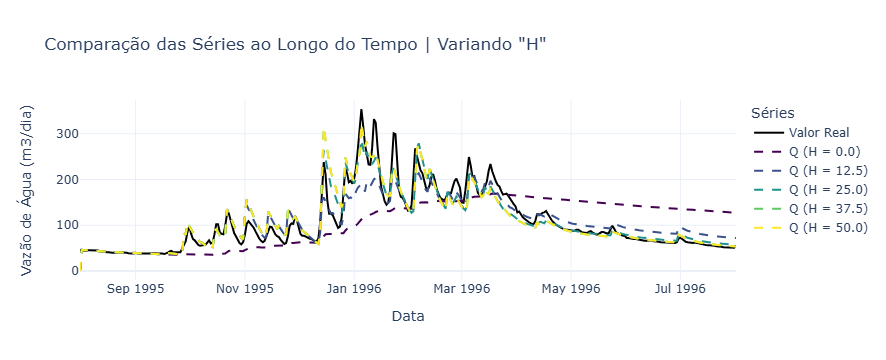

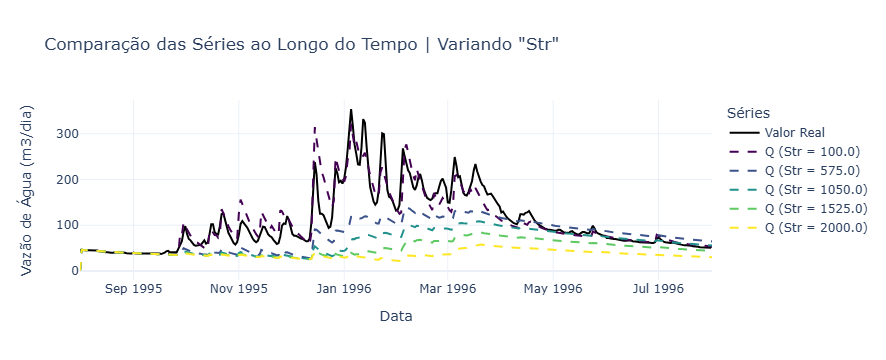

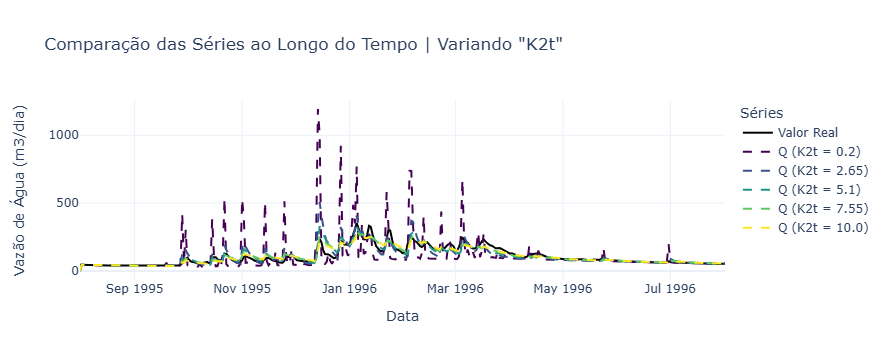

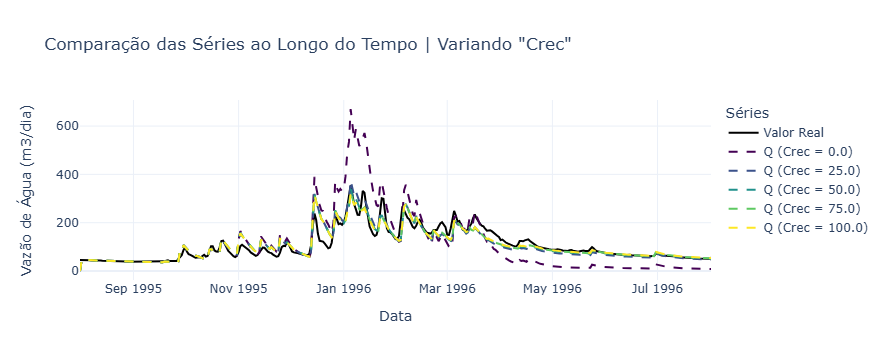

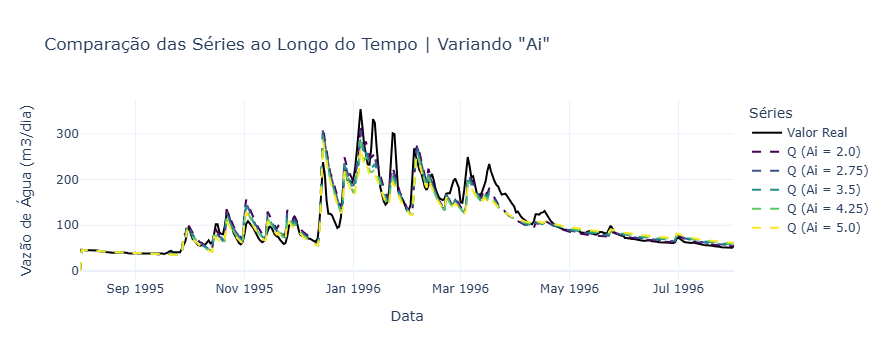

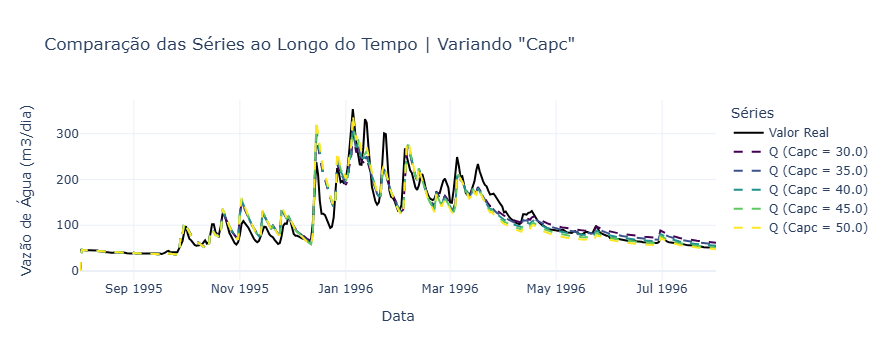

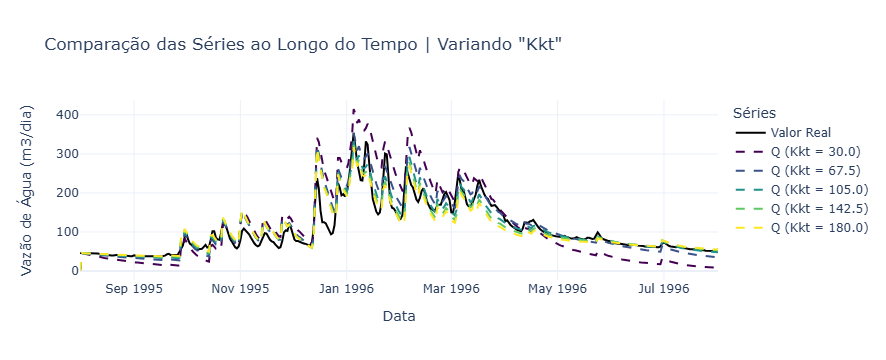

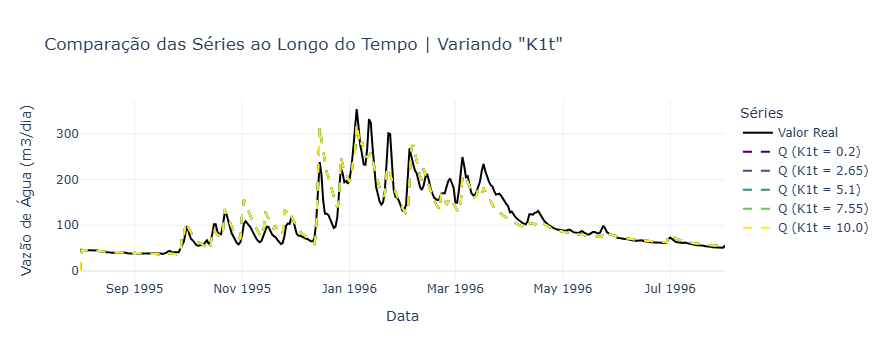

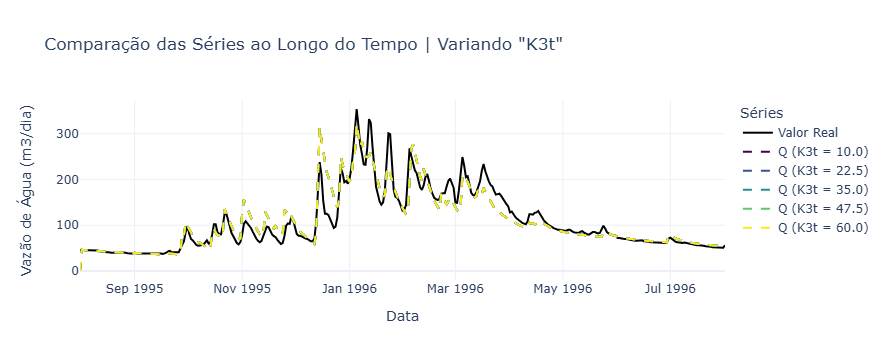

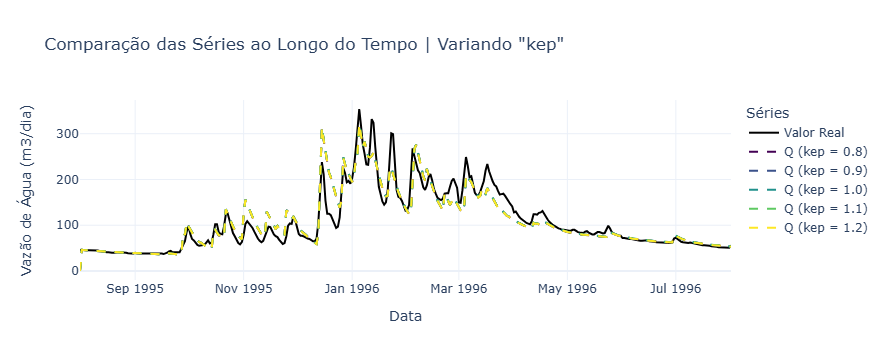

In [14]:
import numpy as np
from modules.smap import ModeloSmapDiario

# Define the parameter grid based on the ranges provided
param_grid = {
    'H': np.linspace(0, 50, 5), # 0.96
    'Str': np.linspace(100, 2000, 5), # 1.19
    'K2t': np.linspace(0.2, 10, 5),  # 0.99
    'Crec': np.linspace(0, 100, 5), # 1.00
    'Ai': np.linspace(2, 5, 5), # 0.99
    'Capc': np.linspace(30, 50, 5), # 1.01
    'Kkt': np.linspace(30, 180, 5), # 1.02
    'K1t': np.linspace(0.2, 10, 5), # 0.96
    'K3t': np.linspace(10, 60, 5), # 0.96
    'kep': np.linspace(0.8, 1.2, 5), # 0.96
}

params_default = params_ons
# params_default = params_middle

preds = data[['Qobs']]
preds.columns = ['Q - OBS']
preds.index.name = 'index'

figs = []
for key, values in param_grid.items():
    for value in values:
        params = {**params_default, key: value}
        result = ModeloSmapDiario(Ep=Ep, Pr=Pr, **params)
        preds[f'Q ({key} = {round(value, 2)})'] = result['Q']
    
    fig = lines_gradient(preds, title=f'Comparação das Séries ao Longo do Tempo | Variando "{key}"')
    figs.append(fig)
    preds = preds[['Q - OBS']]



#### Salvando gráficos como html

In [15]:
import plotly.graph_objects as go
import plotly.io as pio

path = 'web-apps/sensibilidade_ons.html'

# Combine figures into a single HTML file
with open(path, 'w', encoding='utf-8') as out:
    out.write('''<!DOCTYPE html>
<html lang="pt">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Análise de Sensibilidade do Modelo SMAP - Bacia de Camargos</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {font-family: 'Arial', sans-serif; margin: 0; padding: 0; background-color: #f4f4f4; color: #333;}
        .container {width: 90%; max-width: 1200px; margin: 20px auto; padding: 20px; background-color: #fff; box-shadow: 0 0 10px rgba(0, 0, 0, 0.1); border-radius: 8px;}
        h1, h2 {text-align: center; color: #2c3e50;}
        h1 {margin-bottom: 30px;}
        h2 {margin-bottom: 20px; margin-top: 40px;}
        .section {margin-bottom: 40px;}
        .plot-container {text-align: center;}
        footer {text-align: center; margin-top: 30px; padding: 10px 0; background-color: #2c3e50; color: white;}
    </style>
</head>
<body>
<div class="container">
<h1>Análise de Sensibilidade do Modelo SMAP - Bacia de Camargos</h1>
<div class="section">
<h2>Análise de Sensibilidade (Ago 1995 - Jul 1996)</h2>
<div class="plot-container">''')
    
    for fig in figs:
        out.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

    # out.write('''</div></div><div class="section"><h2>Validação do Modelo (Ago 2000 a Dez 2007)</h2><div class="plot-container">''')

    # for fig in figures_val:
        # out.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
    
    out.write('''</div></div></div><footer>&copy; 2024 Análise dos Resultados do Modelo SMAP - Bacia de Camargos</footer></body></html>''')
